In [1]:
import sys
sys.path.append("/home/vpetukhov/other/NLPProjects/DocumentMap/")

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pickle
from gensim.models import KeyedVectors
import umap
import pygsp
import re

from scripts.reports import *
from scripts.word_cloud import *
from scripts.graph_utils import *
from scripts.hierarchy_utils import *
from scripts.plot_utils import *
from scripts.keywords_utils import *
from scripts.data_prepare_for_dash import *
from scripts.preprocessing import *
from scripts.lsi_utilites import *
from scripts.utils import *

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
%time wv_embeddings = KeyedVectors.load_word2vec_format("/home/vpetukhov/data_nlp/embeddings/GoogleNews-vectors-negative300.bin", binary=True)

CPU times: user 24.5 s, sys: 3.53 s, total: 28 s
Wall time: 28.6 s


In [3]:
import json
def replace_single_quotes(x:str):
    return re.sub(string=x, pattern=r"(([ {\[])')|('([:},\]]))", repl=r'\2"\4')

In [4]:
data = pd.read_csv('./data/posts.csv')
data['text'] = data['title'] + "\n" + data['body']
data = data[~data['text'].isna()]
data['postedAt'] = pd.to_datetime(data['postedAt'])
data['user'] = data.user.map(lambda x: json.loads(replace_single_quotes(x))['username'] if not pd.isna(x) else '-')
data['tags'] = data['tags'].map(lambda x: json.loads(replace_single_quotes(x)))

In [5]:
data['documents_norm'] = data.text.progress_map(normalize_text_doc)

  0%|          | 0/10696 [00:00<?, ?it/s]

In [6]:
text_embeddings = np.r_[[words_to_vec(d, wv_embeddings) for d in tqdm(data.documents_norm.values)]]
assert sum(np.linalg.norm(v) < 1e-5 for v in text_embeddings) == 0

  0%|          | 0/10696 [00:00<?, ?it/s]

## Experiments with UMAP

### mNN

In [7]:
from src.mnn_umap import prepare_umap_graph, full_umap

In [8]:
umap_graph = prepare_umap_graph(text_embeddings, metric="cosine", init_nn=30, connectivity="min_tree", verbose=False)

In [9]:
mnn_emb = full_umap(
    text_embeddings, umap_graph, spread=10, min_dist=0.5, metric="cosine", random_state=42, verbose=True, n_epochs=2000
)

/home/vpetukhov/local/miniconda3/envs/pip/lib/python3.8/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
100%|██████████| 2000/2000 [01:26<00:00, 23.00it/s]


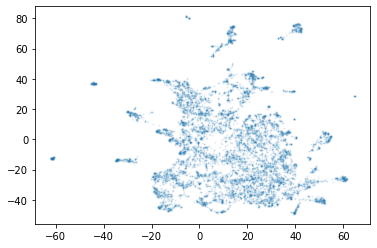

In [10]:
plt.scatter(mnn_emb[:,0], mnn_emb[:,1], s=1.0, marker='o', alpha=0.1);

### densMAP

In [11]:
densmap = umap.UMAP(metric="cosine", spread=2, min_dist=1, densmap=True, dens_lambda=5, random_state=42)
%time dens_emb = densmap.fit_transform(text_embeddings)

CPU times: user 32.4 s, sys: 2.87 s, total: 35.3 s
Wall time: 25.2 s


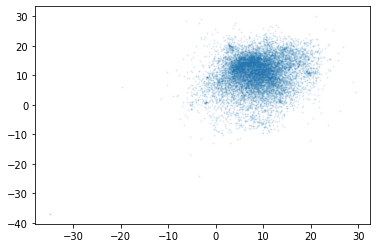

In [12]:
plt.scatter(dens_emb[:,0], dens_emb[:,1], s=1.0, marker='o', alpha=0.1);

### Default UMAP

In [13]:
ump = umap.UMAP(metric="cosine", spread=7, min_dist=0.25)
%time embedding = ump.fit_transform(text_embeddings)

/home/vpetukhov/local/miniconda3/envs/pip/lib/python3.8/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


CPU times: user 44.4 s, sys: 1.87 s, total: 46.2 s
Wall time: 6.39 s


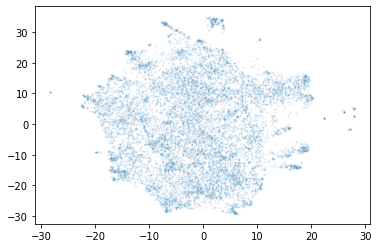

In [14]:
plt.scatter(embedding[:,0], embedding[:,1], s=1.0, marker='o', alpha=0.1);

## Clustering and keywords

In [15]:
i_graph = get_igraph_from_umap_graph(None, graph=umap_graph)

In [16]:
clustering_info = two_level_clustering(
    i_graph, data.documents_norm.values, top_level_resolution=0.0015, second_level_resolution=0.002
)

len(set(clustering_info['clusters_1_level'])), len(set(clustering_info['global_numbering_clusters_2_level']))

(20, 61)

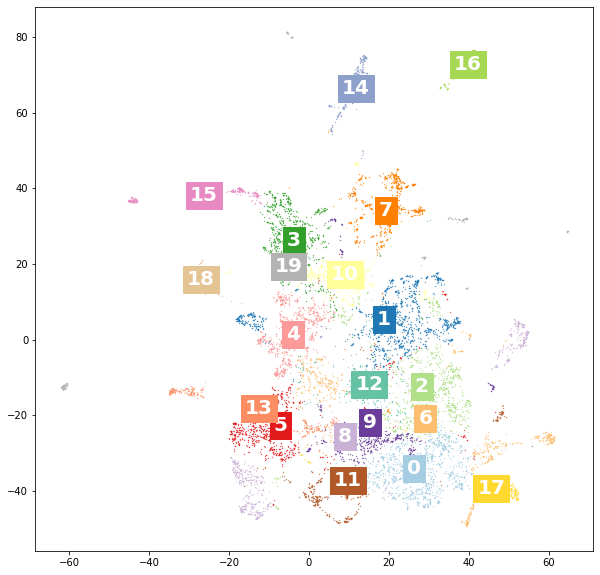

In [17]:
draw_clusters_with_label(mnn_emb, clustering_info['clusters_1_level'], min_cluster_size=50, figsize=(10, 10), s=0.1)

In [18]:
%time text_corp, vectorizer = create_text_corp(data.text.values)

CPU times: user 2min 9s, sys: 362 ms, total: 2min 9s
Wall time: 2min 10s


In [19]:
res_kw = get_key_words_for_hierarchy(clustering_info, data.documents_norm, text_corp, vectorizer)

In [20]:
data['day'] = (data.postedAt - data.postedAt.min()).map(lambda x: x.days)

In [21]:
clust_labels = np.array([f'{i}.' + '-'.join(x.split(',')[:3]) for i,x in enumerate(res_kw['tfidf_kw_1_level'])])
clust_labels = clust_labels[clustering_info['clusters_1_level']]

uniq_inds = np.unique(res_kw['local_numbering_clusters_2_level'], return_index=True)[1]
levels2 = res_kw['local_numbering_clusters_2_level'][uniq_inds][np.argsort(res_kw['global_numbering_clusters_2_level'][uniq_inds])]

clust_labels2 = np.array([f'{n}.' + '-'.join(x.split(',')[:3]) for n,x in zip(levels2, res_kw['tfidf_kw_2_level'])])
clust_labels2 = clust_labels2[clustering_info['global_numbering_clusters_2_level']]

## Create the final data

In [22]:
graph = pygsp.graphs.Graph(umap_graph)
graph.estimate_lmax()

In [23]:
# del data['url']
sel_cols = ['title', 'text', 'date', 'url', 'baseScore', 'voteCount', 'day', 'meta', 'question', 'tags', 'user', 'documents_norm']
art_df = data.rename(columns={'pageUrl': 'url', 'postedAt': 'date'})[sel_cols].copy()
art_df['tags'] = art_df['tags'].map('; '.join)

art_df['clust1'] = clust_labels
art_df['clust2'] = clust_labels2

In [24]:
list_bows = [bag_words(tn) for tn in data.documents_norm.values]

res_arch = dict(
    res_kw=res_kw,
    umap_3d=mnn_emb,
    graph=graph,
    art_df=art_df,
    total_bows=create_total_bow(list_bows),
    word_freq_docs=create_words_freq_docs(list_bows),
    bow=list_bows
)

%time res_arch['lsi_info'] = build_lsi_index(data.documents_norm.values)

CPU times: user 1min 41s, sys: 18.1 s, total: 1min 59s
Wall time: 27.5 s


In [25]:
res_arch['clusters_columns'] = ['clust1', 'clust2', 'day'] # , 'meta', 'question'
res_arch['metadata_columns'] = ['title', 'user', 'date', 'tags', 'baseScore', 'voteCount']
res_arch['art_df'] = art_df
res_arch['metadata'] = art_df[res_arch['metadata_columns']].to_dict()

In [26]:
pd.to_pickle(res_arch, 'output/data_mnn_w2v.pickle')

TODO:
- [ ] Replace 'day' with 'year'
- [ ] Add parameters for point size and cluster labels
- [ ] Create a clean repo from DMTransfer and put everything there
- [ ] Update dependencies to the most resent versions
- [ ] Fix plotly colormaps
- [ ] In trends, set months to default
- [ ] Normalize trends ober total count
- [ ] **Think on how this can help forum (see their notes)**